In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [13]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

model = VGG16(weights = 'imagenet')

In [3]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = '/content/drive/MyDrive/Colab Notebooks/ICT 이노베이션 스퀘어/06 02 Style Transfer/creative_elephant.jpg'

img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [4]:
preds = model.predict(x)
print('Predicted', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted [('n02504458', 'African_elephant', 0.90942043), ('n01871265', 'tusker', 0.08618348), ('n02504013', 'Indian_elephant', 0.004354588)]


In [5]:
np.argmax(preds[0])

386

In [6]:
    # 예측 벡터의 '아프리카 코끼리' 항목
    african_elephant_output = model.output[:, 386]
    
    # VGG16의 마지막 합성곱 층인 block5_conv3 층의 특성 맵
    last_conv_layer = model.get_layer('block5_conv3')

    # block5_conv3의 특성 맵 출력에 대한 '아프리카 코끼리' 클래스의 그래디언트
    grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

    # 특성 맵 채널별 그래디언트 평균 값이 담긴 (512,) 크기의 벡터
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # 샘플 이미지가 주어졌을 때 방금 전 정의한 pooled_grads와 block5_conv3의 특성 맵 출력을 구합니다
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    # 두 마리 코끼리가 있는 샘플 이미지를 주입하고 두 개의 넘파이 배열을 얻습니다
    pooled_grads_value, conv_layer_output_value = iterate([x])

    # "아프리카 코끼리" 클래스에 대한 "채널의 중요도"를 특성 맵 배열의 채널에 곱합니다
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵입니다
    heatmap = np.mean(conv_layer_output_value, axis=-1)

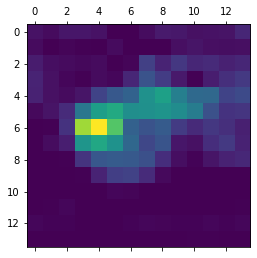

In [14]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [17]:
import cv2

img = cv2.imread(img_path)
# heatmap을 원본 이미지 크기에 맞게 변경
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# heatmap을 RGB 포맷으로 변환
heatmap = np.uint8(255 * heatmap)
# 히트맵으로 변환
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# 0.4는 히트맵의 강도
superimposed_img = heatmap * 0.4 + img

cv2.imwrite('./creative_elephant.jpg', superimposed_img)

True